In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
#Training parameters
n_epochs = 4
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

In [ ]:
random_seed = 3
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)


In [ ]:
#Load datasets
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.RandomAffine(degrees = (-0,0),translate=(0.1,0.1)),  
                               torchvision.transforms.ToTensor(),
                               
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.RandomAffine(degrees = (-0,0),translate=(0.1,0.1)),  
                               torchvision.transforms.ToTensor(),
                               
                             ])),
  batch_size=batch_size_test, shuffle=True)



train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
#Lets train the network using pytorch

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)
#The forward part needs to be implemented manualy
  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)       #Not usefull for inference
    x = self.fc2(x)
    return F.log_softmax(x) 

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
print(network.named_parameters)
print(" OUTPUT 1 from conv2: \n [first filter 10,5,5] \n x \n [imageSnip 10 5 5]")
print("#########")
print( sum(p.numel() for p in network.parameters() if p.requires_grad) )
print("Versus How many trainable parameters there are in the model in tiny dnn: 25450")

<bound method Module.named_parameters of Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)>
 OUTPUT 1 from conv2: 
 [first filter 10,5,5] 
 x 
 [imageSnip 10 5 5]
#########
21840
Versus How many trainable parameters there are in the model in tiny dnn: 25450


In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3061, Accuracy: 1136/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316510
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.305950
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.312108
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.312695
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.302918
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.301116
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.298078
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.285862
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.289174
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.292151
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.294726
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.298260
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.315935
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.299824
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.293559
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.275867
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.273023
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.262600
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.269088
Train Epoch: 1 [12160

In [ ]:
#Lets extract an example of an image to perform inference
experiment_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.RandomAffine(degrees = (-0,0),translate=(0.1,0.1)),  
                               torchvision.transforms.ToTensor(),
                               
                             ])),
  batch_size=1, shuffle=True)

In [ ]:
#Function thats snips out a list out of a bigger list
def snipImage(im, x0, y0, size = 5):
  snip = [ [0]*(size) for i in range(size)]
  for i in range(size):
    for j in range(size):
      snip[i][j] = im[y0+i][x0+j]
  return snip



#does a convolutional operation of a kernel on an image part of the same size, returns the x/+
def ConvSum(im,ker,size = 5):
  sum = 0
  for i in range(size):
    for j in range(size):
      sum += im[i][j]*ker[i][j]
  
  return sum

#####################
######################

#Test the snip method
#a = snipImage(image,9,2)
#for i in range(5):
#    for j in range(5):
#        p = a[i][j]*255
#        print("%3d" % p, end=" ")
#    print()
###
#
#
#Test the summation method
#print(ker1[0][0])
#sum1 = ConvSum(a, ker1[0][0])
#sum2 = ConvSum(a, ker1[1][0])
#print(sum1,sum2)


In [ ]:
bias1 = network.conv1.bias.tolist()
ker1 = network.conv1.weight.tolist()


def CONV1(x):

  OUT = [[[0]*24 for i in range(24)] for i in range(10)]

  for k in range(10):
    curr_y = out_y = 0
    # move filter vertically
    while curr_y + 5 <= 28:
      curr_x = out_x = 0
      # move filter horizontally across the image 
      while curr_x + 5 <= 28:
        # perform the convolution operation and add the bias
        OUT[k][out_y][out_x] = ConvSum(snipImage(x, curr_x, curr_y), ker1[k][0]) + bias1[k]            #Snip testes it works
        curr_x += 1
        out_x += 1
      curr_y += 1
      out_y += 1
        
  return OUT


#RELU Function
def RELU_C(conv1_out):
  for k in range(np.shape(conv1_out)[0]):
    for i in range(np.shape(conv1_out)[1]):
      for j in range(np.shape(conv1_out)[2]):
        if conv1_out[k][i][j]<0 :
          conv1_out[k][i][j] = 0


#Pooling layer:
def maxL(x):
  l=[0,0]
  l[0] = max(x[0])
  l[1] = max(x[1])
  return(max(l))

def maxPool1(x):
  #feature map input shape: [10,24,24]
  output = [[[0]*12 for i in range(12)]for i in range(10)]
  
  for k in range(10): #n_c
    print(k)
    curr_y = out_y = 0
    # slide the max pooling window vertically
    while curr_y + 2 <= 24:
      curr_x = out_x = 0
      # slide the max pooling window horizontally
      while curr_x + 2 <= 24:
        output[k][out_y][out_x] = maxL(snipImage(x[k], curr_x, curr_y, size=2))
        #print(out_y)
       # print(output[k][out_y][out_x])
        curr_x += 2
        out_x += 1
      curr_y += 2
      out_y += 1
  
  return output


#CONV2
ker2 = network.conv2.weight.tolist()
bias2 = network.conv2.bias.tolist()

def CONV2(x):   #20 filters of size 10x5x5
  output = [[[0]*(8) for i in range(8)] for i in range(20)]

  #Number of filters n_f
  for k in range(20): 
    curr_y = out_y = 0
    # move filter vertically
    while curr_y + 5 <= 12:
      curr_x = out_x = 0
      # move filter horizontally
      while curr_x + 5 <= 12:
        # perform the convolution operation and add the bias on all dimensions off the image 10x5x5
        csum = 0
        for p in range(10):
          csum = csum + ConvSum(snipImage(x[p], curr_x, curr_y), ker2[k][p])
        
        output[k][out_y][out_x] = csum + bias2[k]
        curr_x += 1
        out_x += 1
      curr_y += 1
      out_y += 1

  return output


#max_Pool2 
def maxPool2(x):
  #feature map input shape: [20,8,8]
  output = [[[0]*4 for i in range(4)]for i in range(20)]
  
  for k in range(20): #n_c
    curr_y = out_y = 0
    # slide the max pooling window vertically
    while curr_y + 2 <= 8:
      curr_x = out_x = 0
      # slide the max pooling window horizontally
      while curr_x + 2 <= 8:
        output[k][out_y][out_x] = maxL(snipImage(x[k], curr_x, curr_y, size=2))
        curr_x += 2
        out_x += 1
      curr_y += 2
      out_y += 1
  
  return output

tensor([5])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


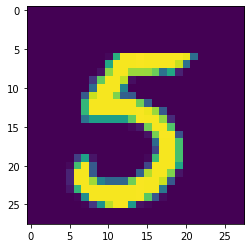

In [ ]:
# get some random testing images
dataiter = iter(experiment_loader)
image, label = dataiter.next()
plt.imshow(image[0][0])

output = network(image)     #INFERENCE THAT NEEDS TO BE IMPLEMENTED BY HAND
pred = output.data.max(1)[1]
print(pred)

In [ ]:
image = image[0][0].tolist()
print(np.shape(image))

for i in range(28):
    for j in range(28):
        p = image[i][j]*255
        print("%3d" % p, end=" ")
    print()

(28, 28)
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   5 162 253 253 255 253 253 253 253 253 249  92   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0 153 252 252 252 253 252 252 252 252 234  95   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0  11 212 252 252 217 217 216 198  96 153  23   0   0

In [ ]:
#####################
#####################

#Test Conv1 -> maxPool1
test_CONV1 = CONV1(image)
print(test_CONV1[0])

[[0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042], [0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042], [0.3132571876049042, 0.313257187604

In [ ]:
test_maxPool1 = maxPool1(test_CONV1)
print(test_maxPool1)

0
1
2
3
4
5
6
7
8
9
[[[0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042], [0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.5210514448867829, 1.4476438567335776, 1.6787183982611444, 1.6861763911787855, 1.6834373127759075, 1.6621101105872054, 0.9751701741900918, 0.5025497503666961, 0.3132571876049042], [0.3132571876049042, 0.3132571876049042, 0.3457066925826894, 1.147743156655876, 1.4834487548044502, 1.4080366977602987, 1.3107999296822799, 1.2492100477013302, 0.9441660469430886, 0.2532352857676028, 0.28122992173097217, 0.3132571876049042], [0.3132571876049042, 0.32037424337605547, 0.7524168185014685, 1.4465375798246058, 1.1373262149269063, -0.3390975736654849, -1.1391999177705947, -1.1492862435426863, -0.7619078271122901, -0.09231977596448337, 0.3132571876049042, 0.3132571876049042], [0.

In [ ]:
RELU_C(test_maxPool1)
print(np.shape(test_maxPool1))
print(test_maxPool1)

(10, 12, 12)
[[[0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.3132571876049042], [0.3132571876049042, 0.3132571876049042, 0.3132571876049042, 0.5210514448867829, 1.4476438567335776, 1.6787183982611444, 1.6861763911787855, 1.6834373127759075, 1.6621101105872054, 0.9751701741900918, 0.5025497503666961, 0.3132571876049042], [0.3132571876049042, 0.3132571876049042, 0.3457066925826894, 1.147743156655876, 1.4834487548044502, 1.4080366977602987, 1.3107999296822799, 1.2492100477013302, 0.9441660469430886, 0.2532352857676028, 0.28122992173097217, 0.3132571876049042], [0.3132571876049042, 0.32037424337605547, 0.7524168185014685, 1.4465375798246058, 1.1373262149269063, 0, 0, 0, 0, 0, 0.3132571876049042, 0.3132571876049042], [0.3132571876049042, 0.48261294288849066, 1.200736291770133, 1.4108018138013585, 0.6455499076284938, 

In [ ]:
#Test Conv1 -> maxPool1 -> Conv2
test_conv2 = CONV2(test_maxPool1)
print(np.shape(test_conv2))

(20, 8, 8)


In [ ]:
#Test  Conv1 -> MaxPool1 -> Conv2 -> MaxPool2
test_maxPool2 = maxPool2(test_conv2)
RELU_C(test_maxPool2)
print(np.shape(test_maxPool2))
#print(test_maxPool2)

(20, 4, 4)


In [ ]:
#################

In [ ]:
#Prepare to enter FCL--> flatten the marix 20,4,4
d_flatten = []
for k in range(20):
  for i in range(4):
    for j in range(4):
        d_flatten.append(test_maxPool2[k][i][j])

#test the shape
print(np.shape(d_flatten))

(320,)


In [ ]:
#print(d_flatten)

In [ ]:
fcb1 = network.fc1.bias.tolist()
fcw1 = network.fc1.weight.tolist()
fcb2 = network.fc2.bias.tolist()
fcw2 = network.fc2.weight.tolist()

In [ ]:
#Function FC1
def FC1(x):
  sum = [0 for i in range(50)]
  for k in range(50):
    for i in range(320):
      sum[k] += x[i]*fcw1[k][i]
    
    sum[k] = sum[k] + fcb1[k]

  return sum    

#RELU Function
def RELU(fc1_out):
  for k in range(50):
    if fc1_out[k]<0 :
      fc1_out[k] = 0

#Function FC2
def FC2(x):
  sum = [0 for j in range(10)]
  
  for k in range(10):
    for i in range(50):
      sum[k] += x[i]*fcw2[k][i]
    
    sum[k] = sum[k] + fcb2[k]

  return sum

In [ ]:
FC1_output = FC1(d_flatten)
RELU(FC1_output)
FC2_output = FC2(FC1_output)
print(FC2_output)

[-1.178276534249712, -8.749626238474027, -1.983256216087596, 4.597161357618891, -3.027790240034495, 13.290849888458428, 1.127760428513422, -9.247326920625175, 6.720248207858798, 2.850534974977908]


In [ ]:
solution = np.argmax(FC2_output)
print(solution)

5
